# Ataque de adversario

En este cuaderno, voy a intentar realizar un ataque de adversario sobre una red neuronal construida utilizando Keras/Tensorflow.

Un ataque de adversario consiste en conseguir una imagen que, sin parecer manipulada, una red neuronal la clasifica erróneamente. Con esto, se podría llegar a provocar que, por ejemplo, un coche autónomo al ver una señal de STOP la identifique como una señal de aumento de velocidad, provocando una situación peligrosa.

## Evaluación de la imagen

En primer lugar, voy a realizar una evaluación normal de una imagen de un gato. Para ello, primero importamos las librerías que se van a necesitar.

In [1]:
import tensorflow as tf # Importamos la librería de Tensorflow
import keras # Importamos Keras que trabaja sobre Tensor facilitándonos el trabajo
import matplotlib.pyplot as plt # Importamos Matplotlib para poder mostrar gráficas
import numpy as np # Importamos la librería Numpy para trabajar con matrices

Using TensorFlow backend.


Ahora, se carga el modelo precargado desde Keras. Es decir, no hay que entrenarlo, ya lo está.

In [2]:
# Importamos los modelos entrenados de Keras, en especial la InceptionV3, de Google y para imágenes, así como, 
# decode_predictions que nos servirá luego para saber que respuesta nos ha dado la red neuronal
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image # Para trabajar con procesado de imágenes

A continuación, se carga el modelo, en este caso "Inception V3", una red neuronal específica para imágenes de Google.

In [3]:
iv3 = InceptionV3()

Finalmente, se va a utilizar la imagen para probar el modelo.

In [4]:
# Cargamos la imagen en una variable como array con un tamaño redimensionado a 299x299
X = image.img_to_array(image.load_img("./gato.png", target_size=(299,299))) 

# InceptionV3 utiliza un formato diferente, el rango de intensidades va de -1 a 1. Vamos a reescalar este rango.
# Pasamos de [0,256) -> [-1,1]

X /= 255 
X -= 0.5 
X *= 2 

La red neuronal pide un formato especial, un tensor, que tiene unas dimensiones específicas, es decir, se necesita una dimensión más:

In [5]:
X = X.reshape([1, X.shape[0], X.shape[1], X.shape[2]])

Ahora, se va a ejecutar la predicción soble la imagen:

In [6]:
y = iv3.predict(X)

Para ejecutar la predicción, se utiliza la librería "decode_prediction" que se ha importado previamente:

In [7]:
decode_predictions(y)

[[('n02124075', 'Egyptian_cat', 0.86809808),
  ('n02123045', 'tabby', 0.073509209),
  ('n02123159', 'tiger_cat', 0.03579814),
  ('n04589890', 'window_screen', 0.0029933434),
  ('n02127052', 'lynx', 0.00035754172)]]

La predicción dice que se trata de un gato egipcio. La imagen utilizada ha sido la siguiente:

In [8]:
# Vamos a reescalar primero el rango de intensidades a como estaba originalmente
X1 = np.copy(X)

X1 /= 2
X1 += 0.5
X1 *= 255

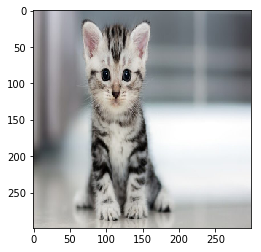

In [9]:
plt.imshow(X1[0].astype(np.uint8))
plt.show()

## Generando la imagen para realizar el ataque de adversario

Ahora se va a generar la nueva imagen, la que provocará que la red neuronal se equivoque. Esto es, ir provocando que se maximice el error:

In [10]:
input_layer = iv3.layers[0].input
output_layer = iv3.layers[-1].output

# Vamos a hacer creer a la red que queremos que lo clasifique como un limón (número 951)
target_class = 951

# Creamos una función de coste para que la última capa el resultado que muestre sea 'target_class'
loss = output_layer[0, target_class]

Ahora es necesario definir el gradiente, para encontrar el mínimo, es decir, el objetivo:

In [11]:
# Nos hace el gráfo entre el valor de entrada y el cálculo del gradiente
grad = K.gradients(loss, input_layer)[0]

# Función que nos hace el cálculo del gradiente
optimize_gradient = K.function([input_layer, K.learning_phase()], [grad, loss])

Una vez hecho esto, falta el bucle donde ejecutar este código:

In [12]:
adv = np.copy(X)

cost = 0.0

while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0]) # Utilizamos la copia que realizamos anteriormente
    adv += gr # Manipulamos los píxeles

Finalmente, se devuelve al rango de intesidades la nueva imagen y se mostrarla:

In [13]:
adv /= 2
adv += 0.5
adv *= 255

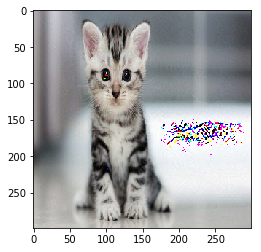

In [14]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

Ahora se tiene la imagen hackeada, y se ven ciertos pixeles que pueden hacer sospechar. Además, se va a guardar dicha imagen para que se persista el resultado:

In [15]:
# Guardamos la imagen
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./gato_hacked.png")

Se carga de nuevo la imagen y se realiza la predicción (se espera que el resultado sea: limón):

In [16]:
# Cargamos la imagen en una variable como array con un tamaño redimensionado a 299x299
img_hacked = image.img_to_array(image.load_img("./gato_hacked.png")) 

# InceptionV3 utiliza un formato diferente, el rango de intensidades va de -1 a 1. Vamos a reescalar este rango.
# Pasamos de [0,256) -> [-1,1]

img_hacked /= 255 
img_hacked -= 0.5 
img_hacked *= 2 

img_hacked = img_hacked.reshape([1, img_hacked.shape[0], img_hacked.shape[1], img_hacked.shape[2]])
y = iv3.predict(img_hacked)

decode_predictions(y)

[[('n07749582', 'lemon', 0.62572002),
  ('n04476259', 'tray', 0.026909433),
  ('n04522168', 'vase', 0.025146704),
  ('n07930864', 'cup', 0.024562402),
  ('n03950228', 'pitcher', 0.018331205)]]

Efectivamente, el resultado dice que lo que ha recibido en la imagen es un limón.

### Minimizar la diferencia entre imágenes

Ahora se quiere decir a la red neuronal que no se extralimite haciendo la manipulación, así la imagen pasará por una imagen normal:

In [ ]:
adv = np.copy(X)

# Límite de la perturbación
pert = 0.01

max_pert = X + pert
min_pert = X - pert

cost = 0.0

while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0]) # Utilizamos la copia que realizamos anteriormente
    adv += gr # Manipulamos los píxeles
    adv = np.clip(adv, min_pert, max_pert) # Ponemos el límite a la perturbación
    adv = np.clip(adv, -1, 1) # Ponemos el límite a la intensidad

Para mostrar el resultado, y ver que la imagen parece que no ha sido alterada:

In [18]:
adv /= 2
adv += 0.5
adv *= 255

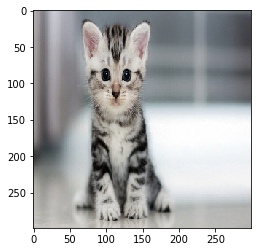

In [19]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

Si realizamos la predicción de nuevo, veremos como nos dice que lo que hay en la imagen es un limón:

In [20]:
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./gato_hacked_good.png")

# Cargamos la imagen en una variable como array con un tamaño redimensionado a 299x299
img_hacked = image.img_to_array(image.load_img("./gato_hacked_good.png")) 

# InceptionV3 utiliza un formato diferente, el rango de intensidades va de -1 a 1. Vamos a reescalar este rango.
# Pasamos de [0,256) -> [-1,1]

img_hacked /= 255 
img_hacked -= 0.5 
img_hacked *= 2 

img_hacked = img_hacked.reshape([1, img_hacked.shape[0], img_hacked.shape[1], img_hacked.shape[2]])
y = iv3.predict(img_hacked)

decode_predictions(y)

[[('n07749582', 'lemon', 0.99910444),
  ('n07747607', 'orange', 0.00026996125),
  ('n09229709', 'bubble', 5.943119e-05),
  ('n07753275', 'pineapple', 4.1333893e-05),
  ('n07718472', 'cucumber', 3.5098896e-05)]]

Finalmente, se obtiene como resultado que lo que tiene la imagen es un limón (a pesar de ser un gato), y la imagen ya no parece modificada.